In [1]:
%matplotlib inline
import os
import joblib
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns

save = False

cm = 1/2.54  # centimeters in inches
sns.set_context('paper', rc={'font.size': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8,
                          'figure.titleweight': 'bold', 'axes.labelsize':10, 'axes.titlesize':12})


dir_path = os.path.abspath('')

output_path = dir_path + '/Figures/'


In [2]:
# load the data
mechanisms = ['inputGain', 'outputGain', 'precision']
tracker = {}
for mechanism in mechanisms:
    tracker[mechanism] = joblib.load(dir_path + '/ModelEvaluation/Performance_' + mechanism + '.pkl')

filename= dir_path + '/ModelEvaluation/Performance_bootstrap.pkl'
num_draws = 500
size_draws = len(tracker['inputGain']['y_test_single'])
np.random.seed(3)
idx = np.arange(size_draws)

if os.path.isfile(filename):
    performance = pd.read_pickle(filename)
    
else:

    performance = pd.DataFrame(np.full((len(mechanisms) * 2 * num_draws,4), np.nan), columns=['Mechanism','Attention', 'Draw', 'AUC'])
    
    performance['Attention'] = np.repeat(np.arange(2)[np.newaxis,:], len(mechanisms) * num_draws, axis=0).flatten()
    performance['Mechanism'] = np.repeat(np.arange(len(mechanisms))[np.newaxis,:],2 * num_draws, axis=1).flatten()
    performance['Draw'] = np.repeat(np.repeat(np.arange(num_draws)[:, np.newaxis],2).flatten()[np.newaxis,:], len(mechanisms),axis=0).flatten()
    
    replace_map = {'Attention': {0: 'valid', 1: 'invalid'}, 'Mechanism': {0: mechanisms[0], 1: mechanisms[1], 2: mechanisms[2]}}
    performance.replace(replace_map, inplace=True)
    
    for m, mechanism in enumerate(mechanisms):
    
        for att in ['valid', 'invalid']:
            for i in range(num_draws):
                # Resampling, with replacement, taking the class imbalance into account
                draw = resample(idx, n_samples=size_draws, random_state=i, stratify=tracker['inputGain']['y_test_single'])
    
                performance.loc[(performance['Mechanism'] == mechanism) & (performance['Attention'] == att) & (
                        performance['Draw'] == i), 'AUC'] = roc_auc_score(tracker['inputGain']['y_test_single'][draw],
                                                                          np.mean(tracker[mechanism]['attention_0.45'][
                                                                                      'testSet'][att][
                                                                                      'predictions'][draw,
                                                                                  tracker['inputGain']['start_eval']:, :],
                                                                                  axis=1))
    
        # Save the results
        performance.to_pickle(filename)
        
# Compare the winning models directly in their performance
# Obtain estimates for analog and baseline
analog_draws = list()
neutral_draws = list()
for i in range(num_draws):
    # Resampling, with replacement, taking the class imbalance into account
    draw = resample(idx, n_samples=size_draws, random_state=i, stratify=tracker['inputGain']['y_test_single'])
    #draw = idx
    analog_draws.append(roc_auc_score(tracker['inputGain']['y_test_single'][draw],tracker['inputGain']['analog_test']['predictions'][draw]))
    neutral_draws.append(roc_auc_score(tracker['inputGain']['y_test_single'][draw],
                                       np.mean(tracker['inputGain']['mf_0.45']['testSet']['predictions'][draw, tracker['inputGain']['start_eval']:, :],
                                                                              axis=1)))


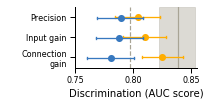

In [3]:
colors = sns.color_palette(sns.xkcd_palette([ "orange yellow","windows blue", "greyish", "faded green", "dusty purple","orange", "grey"]))

sns.set_palette(colors)

dodge = True
capsize = 0.1
aspect = 1.9
errwidth = 1.3  

order = ['precision', 'inputGain', 'outputGain']

g = sns.catplot(y="Mechanism", x='AUC', hue="Attention",
                data=performance,
                height=4 * cm, aspect=aspect, kind="point", palette={'valid': colors[0], 'invalid': colors[1]},
                legend=False, zorder=6, ci=None,
                order=order, join=False, dodge=dodge)

if dodge:
    offset = np.linspace(0, 0.03 * aspect, 2)  
    offset -= offset.mean()
i = 0
for a, att in enumerate(['valid', 'invalid']):
    for m, mechanism in enumerate(order):

        vals = performance.loc[
            (performance['Mechanism'] == mechanism) & (performance['Attention'] == att), 'AUC'].values

        ci_low = np.percentile(vals, 2.5)
        ci_high = np.percentile(vals, 97.5)
        at = np.arange(len(mechanisms))[m] + offset[a]
        g.ax.plot([ci_low, ci_high], [at, at], color=colors[a], zorder=1, lw=errwidth)
        if capsize is not None:
            g.ax.plot([ci_low, ci_low], [at - capsize / 2, at + capsize / 2], color=colors[a], zorder=1,
                      lw=errwidth)
            g.ax.plot([ci_high, ci_high], [at - capsize / 2, at + capsize / 2], color=colors[a], zorder=1,
                      lw=errwidth)

g.set_yticklabels(['Precision', 'Input gain', 'Connection\ngain'])
plt.axvspan(np.percentile(np.array(analog_draws), 2.5), np.percentile(np.array(analog_draws), 97.5),
            color=colors[2], alpha=0.4, zorder=0)
plt.axvline(np.mean(np.array(analog_draws)), color=colors[2], zorder=0)
plt.axvline(np.mean(neutral_draws), color=colors[2],
            ls='--', zorder=0)
limits = np.array([0.75, 0.855])
plt.xlim(limits)

g.ax.set_xlabel('Discrimination (AUC score)')
g.ax.set_xticks([0.75, 0.8, 0.85])
g.ax.set_ylim([2.5, -0.5])

g.ax.set_ylabel(' ')
sns.despine(top=True, right=True)
plt.tight_layout()
if save == True:
    g.savefig(figure_path + 'Performance.pdf', dpi=300, transparent=True)
else:
    plt.show()


In [ ]:
# Statistical analysis, pairwise comparisons per condition
from sklearn.metrics import roc_auc_score
import random

comps = ['valid vs invalid', 'valid vs neutral', 'invalid vs neutral', 'valid vs analog']
results = {}
results_df = pd.DataFrame([], columns=['Mechanism', 'Comparison', 'Difference', 'p-values', 'significant'])
neutralPreds = np.mean(tracker['inputGain']['mf_0.45']['predictions'][:,tracker['inputGain']['start_eval']:, :], axis=1)
sampleYs = np.concatenate([tracker['inputGain']['y_test_single'], tracker['inputGain']['y_test_single']], axis=0)

idx = np.arange(neutralPreds.shape[0]*2)
# Define p (number of permutations):
p = 10000

results['Permutations'] = p
results['alpha-level'] = 0.05 / len(comps)
for mechanism in order:
    if mechanism not in results:
        results[mechanism] = {}
    print(mechanism)
    validPreds = np.mean(tracker[mechanism]['attention_0.45']['testSet']['valid']['predictions'][:,tracker['inputGain']['start_eval']:, :], axis=1)
    invalidPreds = np.mean(tracker[mechanism]['attention_0.45']['testSet']['invalid']['predictions'][:,tracker['inputGain']['start_eval']:, :], axis=1)

    for comp in comps:
        if comp not in results[mechanism]:
            print(comp)
            if comp == 'valid vs invalid':
                diff = np.abs(
                    tracker[mechanism]['attention_0.45']['testSet']['valid']['AUC'] - tracker[mechanism]['attention_0.45']['testSet']['invalid']['AUC'])
                samplePreds = np.concatenate([validPreds, invalidPreds], axis=0)
            elif comp == 'valid vs neutral':
                diff = np.abs(
                    tracker[mechanism]['attention_0.45']['testSet']['valid']['AUC'] - tracker['inputGain']['mf_0.45']['AUC'])
                samplePreds = np.concatenate([validPreds, neutralPreds], axis=0)
            elif comp == 'invalid vs neutral':
                diff = np.abs(
                    tracker[mechanism]['attention_0.45']['testSet']['invalid']['AUC'] - tracker['inputGain']['mf_0.45']['AUC'])
                samplePreds = np.concatenate([invalidPreds, neutralPreds], axis=0)
            elif comp == 'valid vs analog':
                diff = np.abs(
                    tracker[mechanism]['attention_0.45']['testSet']['valid']['AUC'] - tracker['inputGain']['analog_test']['AUC'])
                samplePreds = np.concatenate([validPreds, tracker['inputGain']['analog_test']['predictions']], axis=0)
            else:
                raise ValueError('Comparison is not specified.')

            # Initialize permutation:
            pD = []

            # Permutation loop:
            for i in range(0, p):
                random.shuffle(idx)

                AUC_1st = roc_auc_score(sampleYs[idx[:int(len(idx)//2)], :], samplePreds[idx[:int(len(idx)//2)], :])

                AUC_2nd = roc_auc_score(sampleYs[idx[int(len(idx) // 2):], :], samplePreds[idx[int(len(idx) // 2):], :])

                pD.append(np.abs(AUC_1st - AUC_2nd))


            p_val = len(np.where(pD>=diff)[0])/p
            print(mechanism + ': ' + str(p_val))

            results[mechanism][comp] = {}
            results[mechanism][comp]['Observed difference'] = diff
            results[mechanism][comp]['Difference distribution'] = pD
            results[mechanism][comp]['p-value']= p_val

            results_df = results_df.append({'Mechanism':mechanism, 'Comparison':comp, 'Difference':diff, 'p-values':p_val, 'significant':p_val<results['alpha-level']},ignore_index=True )


joblib.dump(results,
            dir_path + '/ModelEvaluation/PermutationTestsComparisons.pkl',
            compress=True)
results_df.to_csv(dir_path + '/ModelEvaluation/PermutationTestsComparisons_df.csv')
